<a href="https://colab.research.google.com/github/swilsonmfc/imbalanced/blob/main/OverSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Over-Sampling

# Install

In [ ]:
!pip install imblearn

# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from imblearn.pipeline import make_pipeline
from imblearn.base import BaseSampler
from imblearn.metrics import classification_report_imbalanced

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import RandomOverSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Dataset

In [ ]:
def create_dataset(n_samples=1000, weights=(0.02, 0.98), n_classes=2, class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, 
                               random_state=0)

# Helpers

## Plots

In [ ]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    
def plot_comparison(sampler, X, y):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

    pipe = make_pipeline(LinearSVC())
    pipe.fit(X, y)
    plot_decision_function(X, y, pipe, ax1)
    ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

    plot_resampling(X, y, sampler, ax2)
    ax2.set_title('Resampling using {}'.format(type(sampler).__name__))
    fig.tight_layout()

    pipe = make_pipeline(sampler, LinearSVC())
    pipe.fit(X, y)
    plot_decision_function(X, y, pipe, ax3)
    ax3.set_title('Decision function for {}'.format(type(sampler).__name__))
    
    return pipe

## ROC

In [1]:
def plot_roc(technique):
  if technique is None:
    pipe = make_pipeline(SVC(probability=True, gamma='auto'))
  else:
    pipe = make_pipeline(technique, SVC(probability=True, gamma='auto'))

  pipe.fit(X, y)
  probs = pipe.predict_proba(X)
  probs = probs[:, 1]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
 
  #Imbalanced ROC Curve
  fpr, tpr, thresholds = roc_curve(y, probs)
  auc_roc = roc_auc_score(y, probs)
  ax1.plot([0, 1], [0, 1], linestyle='--')
  ax1.plot(fpr, tpr, marker='.')
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  ax1.set_title('ROC Curve - AUC: %.3f' % auc_roc)

  #Precision Recall Curve
  precision, recall, thresholds = precision_recall_curve(y, probs)
  auc_pre_rec = auc(recall, precision)
  no_skill = sum(y) / len(y)
  ax2.plot([0, 1], [no_skill, no_skill], linestyle='--')
  ax2.plot(recall, precision, marker='.')
  ax2.set_xlabel('Recall')
  ax2.set_ylabel('Precision')
  ax2.set_title('Precision Recall Curve - AUC: %.3f' % auc_pre_rec)

  return auc_roc, auc_pre_rec

## Confusion

In [ ]:
def confusion(technique, yHat, y):
    cm = confusion_matrix(y, yHat)
    class_report = classification_report_imbalanced(y, yHat)
    maj_precision = cm[0][0] / (cm[0][0] + cm[1][0])
    maj_recall    = cm[0][0] / (cm[0][0] + cm[0][1])
    min_precision = cm[1][1] / (cm[1][1] + cm[0][1])
    min_recall    = cm[1][1] / (cm[1][1] + cm[1][0])

    plt.figure(figsize=(15,7))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuPu', ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Majority', 'Minority'])
    ax.yaxis.set_ticklabels(['Majority', 'Minority'])

    print(class_report)
    return cm, class_report, (maj_precision, maj_recall), (min_precision, min_recall)

# Tracking

In [ ]:
# Keep a summary of how well different techniques work
cols = pd.MultiIndex.from_tuples(zip(['Majority', 'Majority', 'Minority', 'Minority', 'AUC', 'AUC'],
                                     ['Precision', 'Recall', 'Precision', 'Recall', 'ROC', 'Precision/Recall']))

results_df = pd.DataFrame(columns=cols)

In [ ]:
results_df

Empty DataFrame
Columns: [(Majority, Precision), (Majority, Recall), (Minority, Precision), (Minority, Recall), (AUC, ROC), (AUC, Precision/Recall)]
Index: []

# Baseline

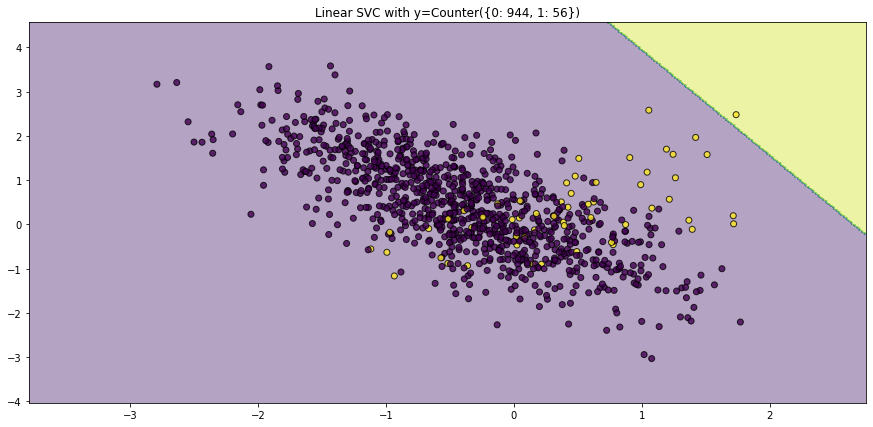

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
X, y = create_dataset(n_samples=1000, weights=(0.95, 0.05), class_sep=0.4)
pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)));

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      1.00      0.02      0.97      0.13      0.02       944
          1       1.00      0.02      1.00      0.04      0.13      0.02        56

avg / total       0.95      0.94      0.07      0.92      0.13      0.02      1000



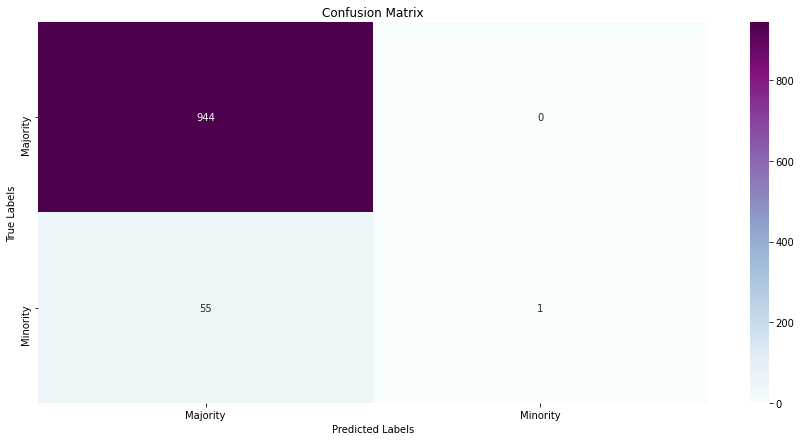

In [ ]:
con, cr, majority, minority = confusion('Baseline', pipe.predict(X), y)

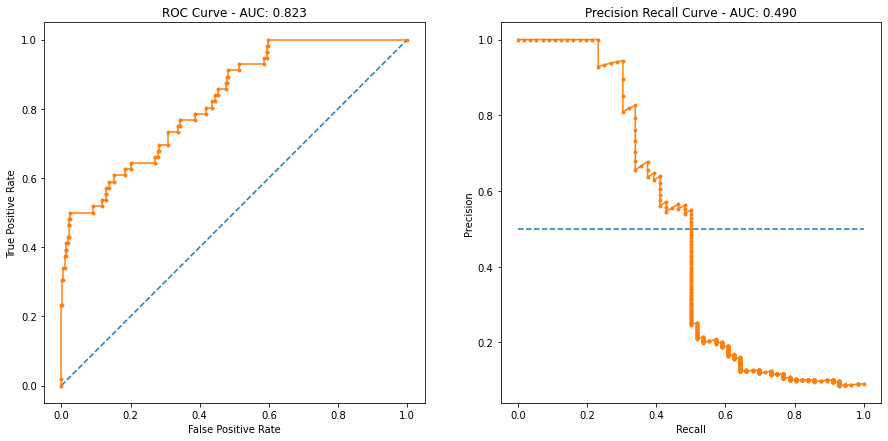

In [ ]:
auc_rec, auc_pre_rec = plot_roc(None)

In [ ]:
results_df.loc['Baseline'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority         Minority                 AUC                 
         Precision Recall Precision    Recall       ROC Precision/Recall
Baseline  0.944945    1.0       1.0  0.017857  0.823301         0.490211

# Over Sampling
Achieve balance by increasing the number of minority classes which reduces the imbalance ratio.

## Random Sampling

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.73      0.71      0.84      0.72      0.52       944
          1       0.14      0.71      0.73      0.23      0.72      0.52        56

avg / total       0.93      0.73      0.72      0.80      0.72      0.52      1000



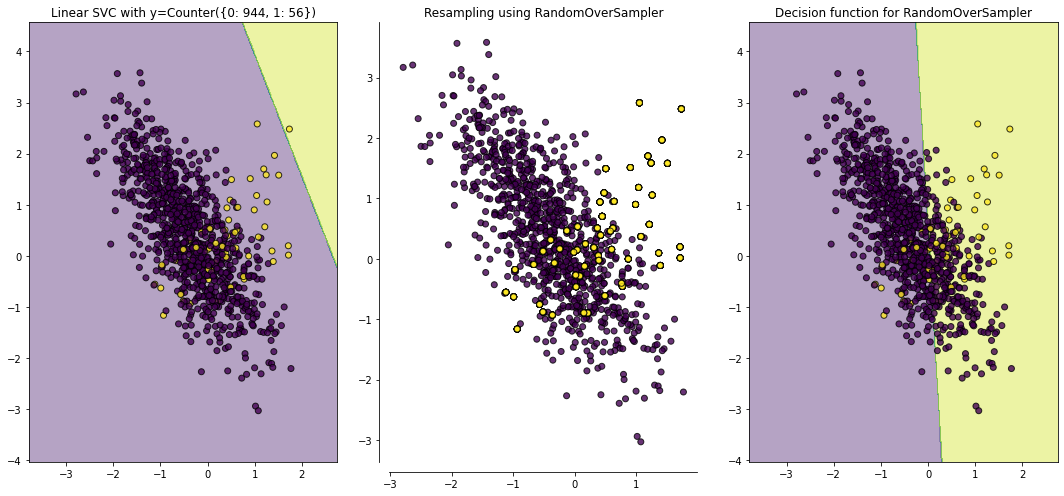

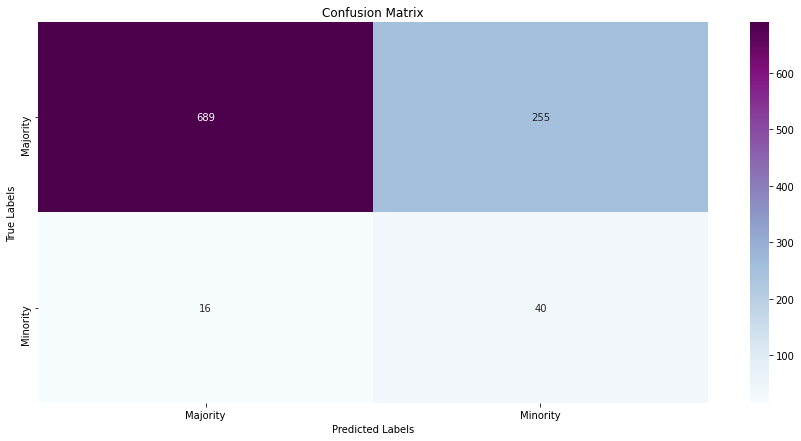

In [ ]:
sampler = RandomOverSampler(random_state=0)
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('Random Over Sampling', pipe.predict(X), y)

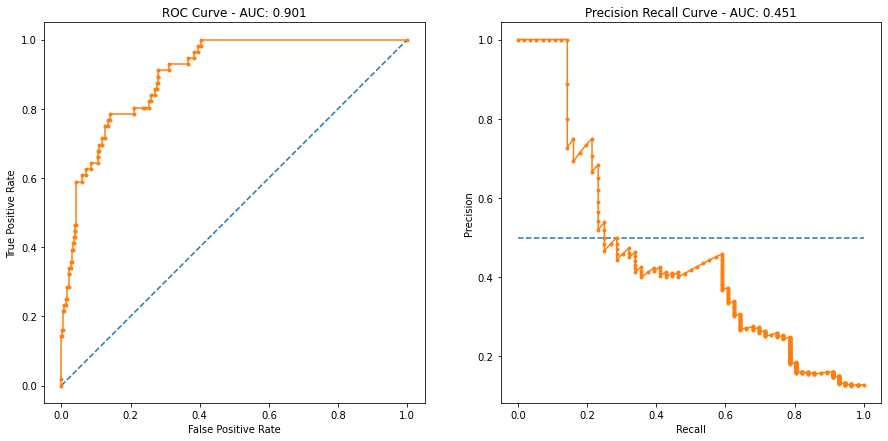

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['Random Over Sampling'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
Baseline              0.944945  1.000000  ...  0.823301         0.490211
Random Over Sampling  0.977305  0.729873  ...  0.901067         0.450717

[2 rows x 6 columns]

## SMOTE
* Synthetic Minority Over Sampling Technique
* http://rikunert.com/SMOTE_explained

![](https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_1.png)

![](https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_2.png)

![](https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png)





                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.73      0.71      0.83      0.72      0.52       944
          1       0.14      0.71      0.73      0.23      0.72      0.52        56

avg / total       0.93      0.73      0.72      0.80      0.72      0.52      1000



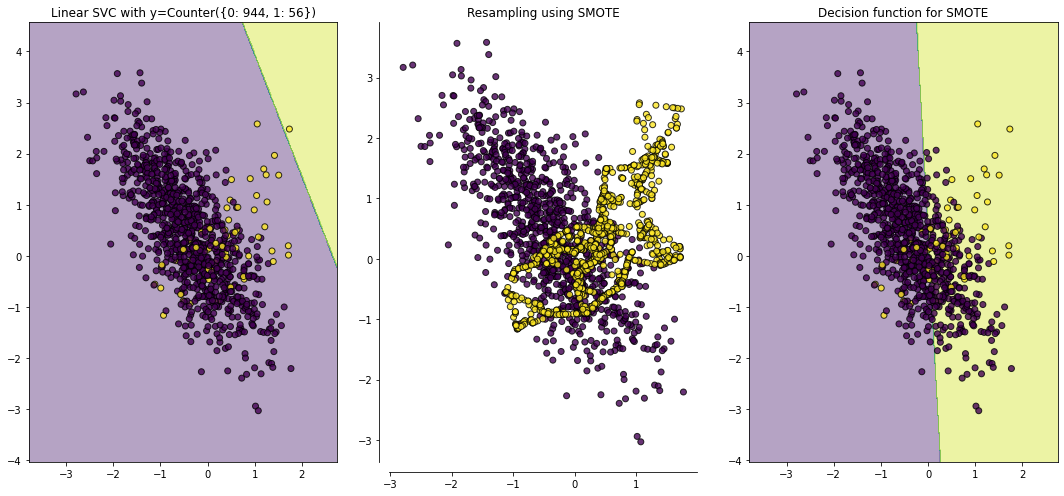

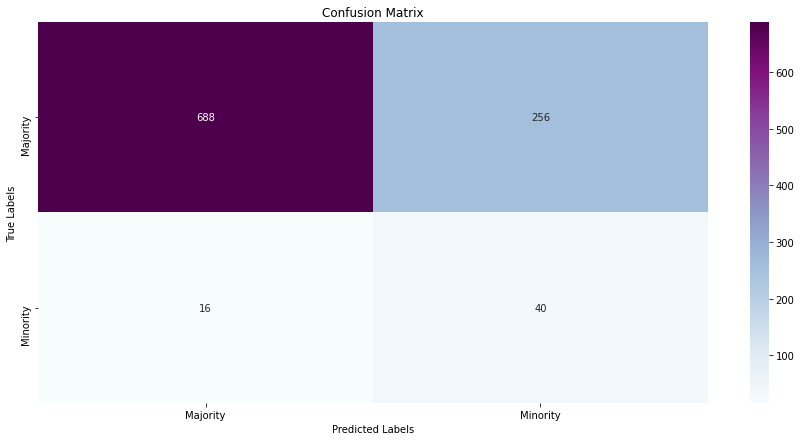

In [ ]:
sampler = SMOTE()
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('SMOTE', pipe.predict(X), y)

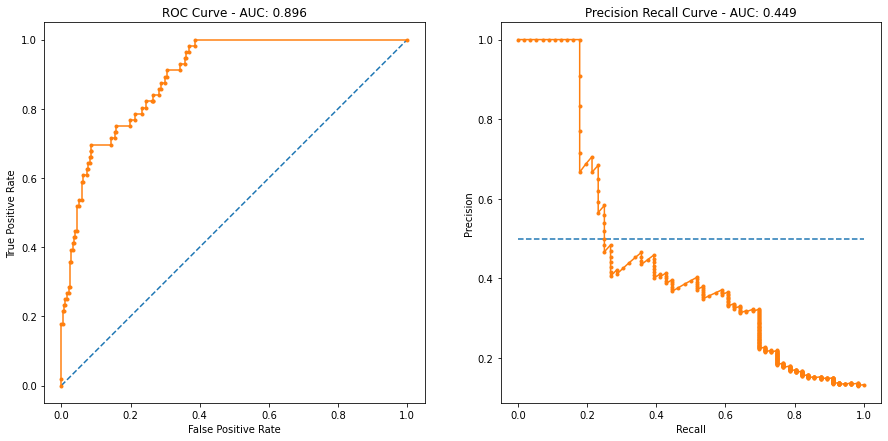

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['SMOTE'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
Baseline              0.944945  1.000000  ...  0.823301         0.490211
Random Over Sampling  0.977305  0.729873  ...  0.901067         0.450717
SMOTE                 0.977273  0.728814  ...  0.896073         0.448683

[3 rows x 6 columns]

## Borderline SMOTE
https://www.datasciencecentral.com/profiles/blogs/dealing-with-imbalanced-datasets

![](https://storage.ning.com/topology/rest/1.0/file/get/2808338577?profile=RESIZE_1024x1024)



### Borderline SMOTE 1





                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.67      0.77      0.80      0.72      0.51       944
          1       0.12      0.77      0.67      0.21      0.72      0.52        56

avg / total       0.93      0.68      0.76      0.76      0.72      0.51      1000



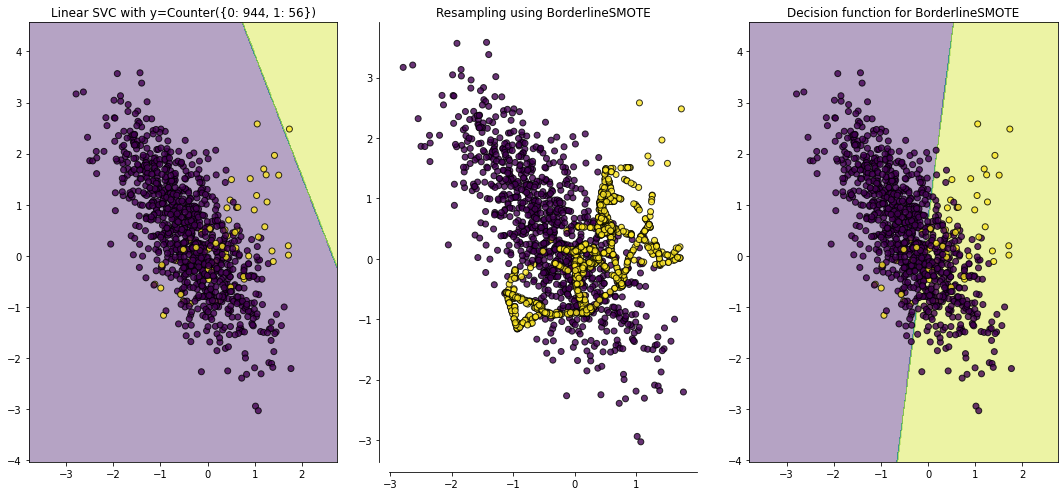

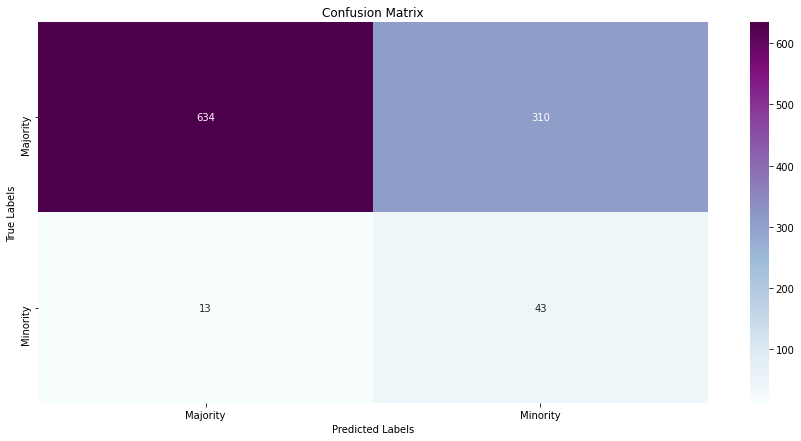

In [ ]:
sampler = BorderlineSMOTE(random_state=0, kind='borderline-1')
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('Borderline SMOTE 1', pipe.predict(X), y)

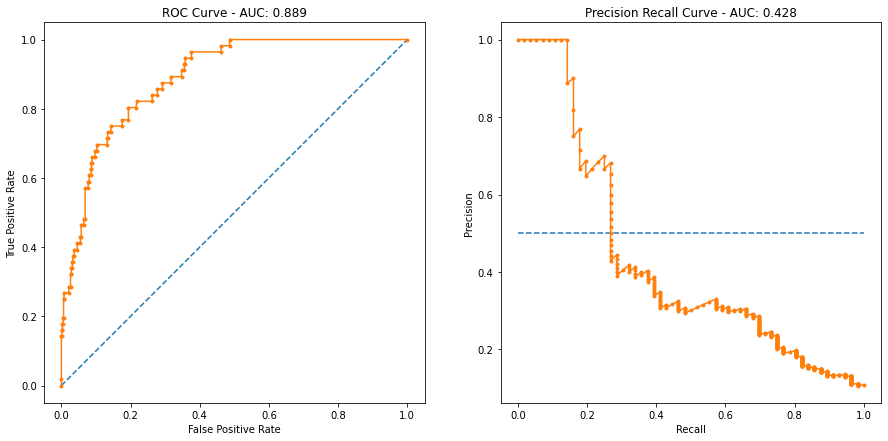

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['Borderline SMOTE 1'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
Baseline              0.944945  1.000000  ...  0.823301         0.490211
Random Over Sampling  0.977305  0.729873  ...  0.901067         0.450717
SMOTE                 0.977273  0.728814  ...  0.896073         0.448683
Borderline SMOTE 1    0.979907  0.671610  ...  0.889131         0.427521

[4 rows x 6 columns]

### Borderline SMOTE 2





                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.66      0.77      0.79      0.71      0.50       944
          1       0.12      0.77      0.66      0.20      0.71      0.51        56

avg / total       0.93      0.66      0.76      0.75      0.71      0.50      1000



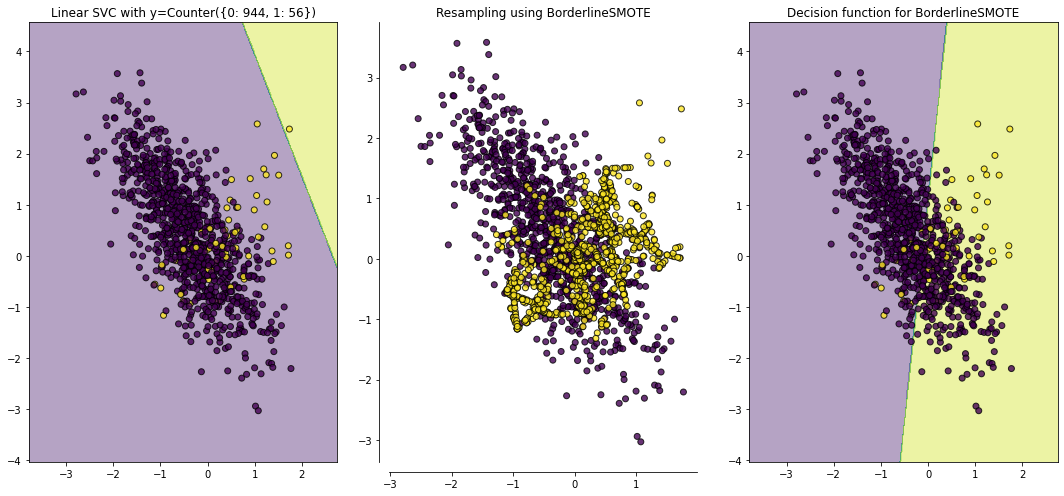

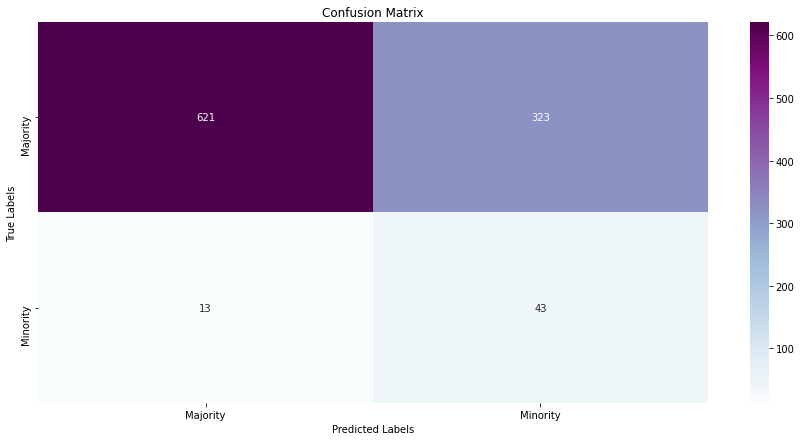

In [ ]:
sampler = BorderlineSMOTE(random_state=0, kind='borderline-2')
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('Borderline SMOTE 2', pipe.predict(X), y)

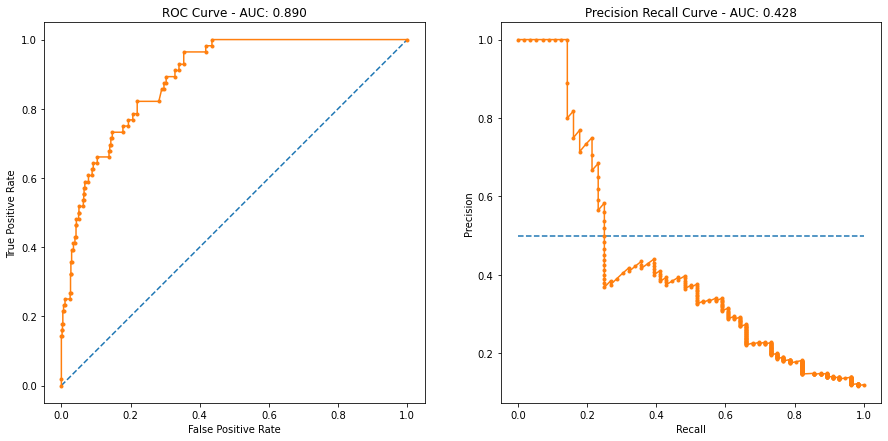

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['Borderline SMOTE 2'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
Baseline              0.944945  1.000000  ...  0.823301         0.490211
Random Over Sampling  0.977305  0.729873  ...  0.901067         0.450717
SMOTE                 0.977273  0.728814  ...  0.896073         0.448683
Borderline SMOTE 1    0.979907  0.671610  ...  0.889131         0.427521
Borderline SMOTE 2    0.979495  0.657839  ...  0.889944         0.427908

[5 rows x 6 columns]

## SVMSMOTE
SVM-SMOTE focuses on generating new minority class instances near borderlines with SVM so as to help establish boundary between classes.
https://medium.com/vclab/tackling-class-imbalance-with-svm-smote-efa41ec3de5f





                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.79      0.61      0.87      0.69      0.49       944
          1       0.14      0.61      0.79      0.23      0.69      0.47        56

avg / total       0.92      0.78      0.62      0.83      0.69      0.49      1000



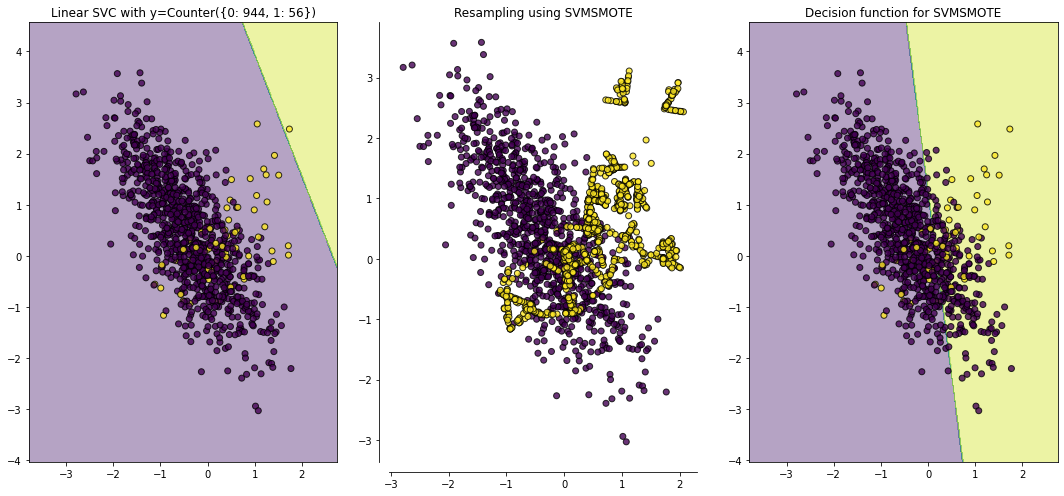

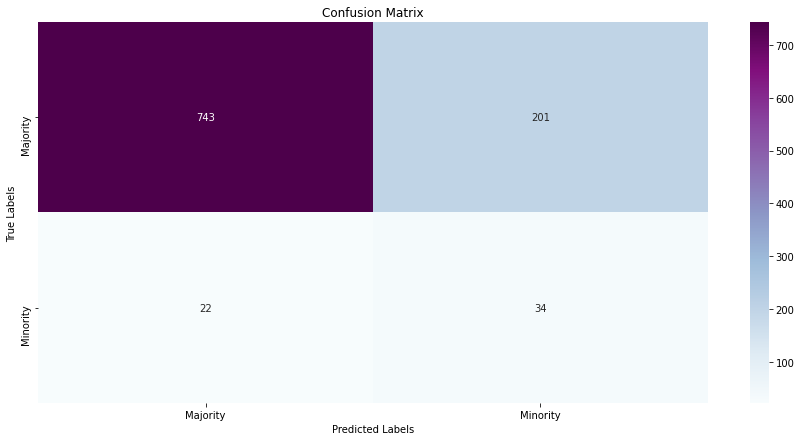

In [ ]:
sampler = SVMSMOTE(random_state=0)
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('SVMSMOTE', pipe.predict(X), y)

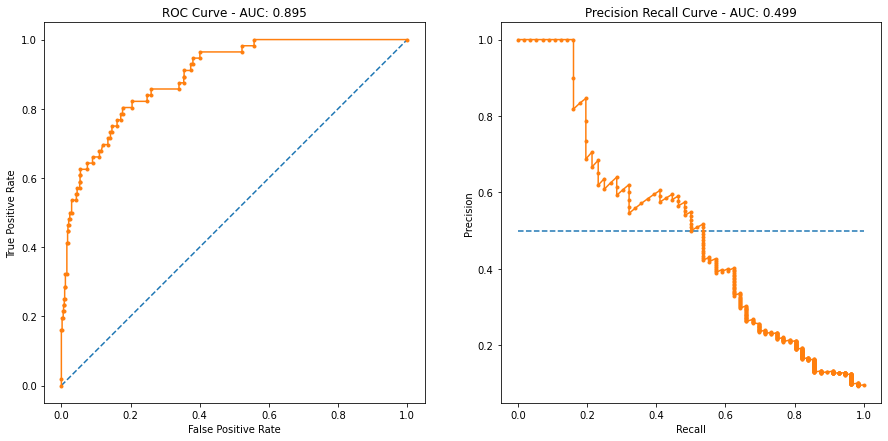

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['SVMSMOTE'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
Baseline              0.944945  1.000000  ...  0.823301         0.490211
Random Over Sampling  0.977305  0.729873  ...  0.901067         0.450717
SMOTE                 0.977273  0.728814  ...  0.896073         0.448683
Borderline SMOTE 1    0.979907  0.671610  ...  0.889131         0.427521
Borderline SMOTE 2    0.979495  0.657839  ...  0.889944         0.427908
SVMSMOTE              0.971242  0.787076  ...  0.895051         0.498578

[6 rows x 6 columns]

## ADASYN
"SMOTE and ADASYN generate new samples in by interpolation. However, the samples used to interpolate/generate new synthetic samples differ. In fact, ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier while the basic implementation of SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule. Therefore, the decision function found during training will be different among the algorithms." https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#cbhk2002



                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.65      0.77      0.78      0.71      0.49       944
          1       0.12      0.77      0.65      0.20      0.71      0.51        56

avg / total       0.93      0.66      0.76      0.75      0.71      0.49      1000



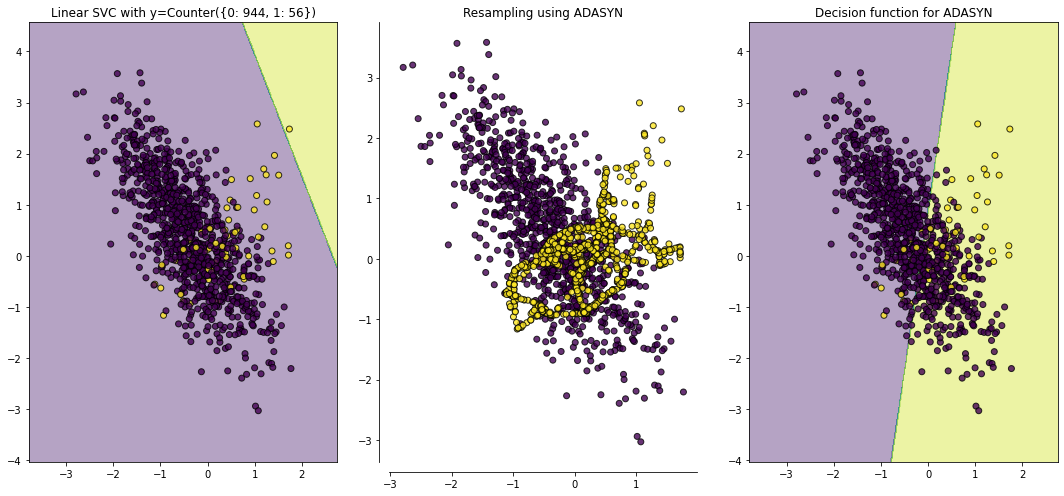

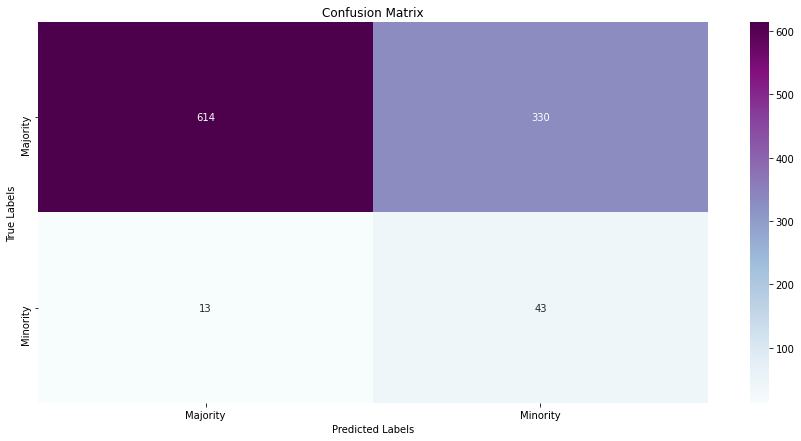

In [ ]:
sampler = ADASYN()
pipe = plot_comparison(sampler, X, y)
con, cr, majority, minority = confusion('ADASYN', pipe.predict(X), y)

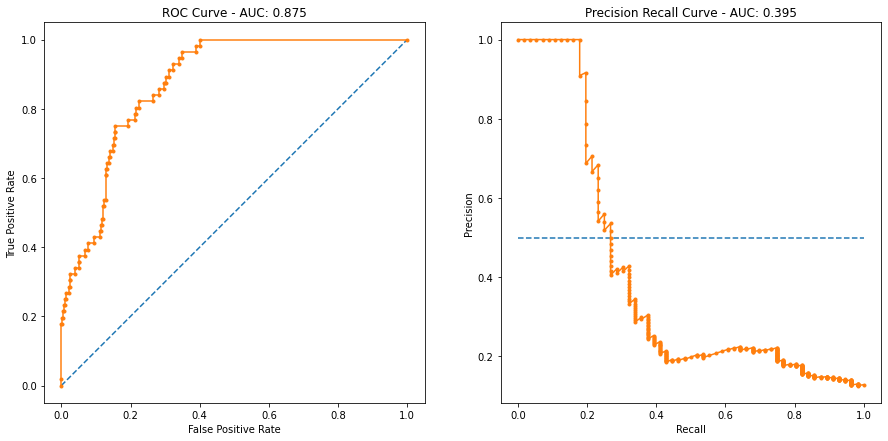

In [ ]:
auc_rec, auc_pre_rec = plot_roc(sampler)

In [ ]:
results_df.loc['ADASYN'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
Baseline              0.944945  1.000000  ...  0.823301         0.490211
Random Over Sampling  0.977305  0.729873  ...  0.901067         0.450717
SMOTE                 0.977273  0.728814  ...  0.896073         0.448683
Borderline SMOTE 1    0.979907  0.671610  ...  0.889131         0.427521
Borderline SMOTE 2    0.979495  0.657839  ...  0.889944         0.427908
SVMSMOTE              0.971242  0.787076  ...  0.895051         0.498578
ADASYN                0.979266  0.650424  ...  0.875492         0.395436

[7 rows x 6 columns]

# Results

## Top Majority Precision

In [ ]:
results_df.sort_values(('Majority', 'Precision'), ascending=False).head(3)

Majority            ...       AUC                 
                   Precision    Recall  ...       ROC Precision/Recall
Borderline SMOTE 1  0.979907  0.671610  ...  0.889131         0.427521
Borderline SMOTE 2  0.979495  0.657839  ...  0.889944         0.427908
ADASYN              0.979266  0.650424  ...  0.875492         0.395436

[3 rows x 6 columns]

## Top Minority Recall

In [ ]:
results_df.sort_values(('Minority', 'Recall'), ascending=False).head(3)

Majority            ...       AUC                 
                   Precision    Recall  ...       ROC Precision/Recall
Borderline SMOTE 1  0.979907  0.671610  ...  0.889131         0.427521
Borderline SMOTE 2  0.979495  0.657839  ...  0.889944         0.427908
ADASYN              0.979266  0.650424  ...  0.875492         0.395436

[3 rows x 6 columns]

## Top AUC

In [ ]:
results_df.sort_values(('AUC', 'ROC'), ascending=False).head(3)

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
Random Over Sampling  0.977305  0.729873  ...  0.901067         0.450717
SMOTE                 0.977273  0.728814  ...  0.896073         0.448683
SVMSMOTE              0.971242  0.787076  ...  0.895051         0.498578

[3 rows x 6 columns]